BERT의 한 종류인 DistilBERT를 사용

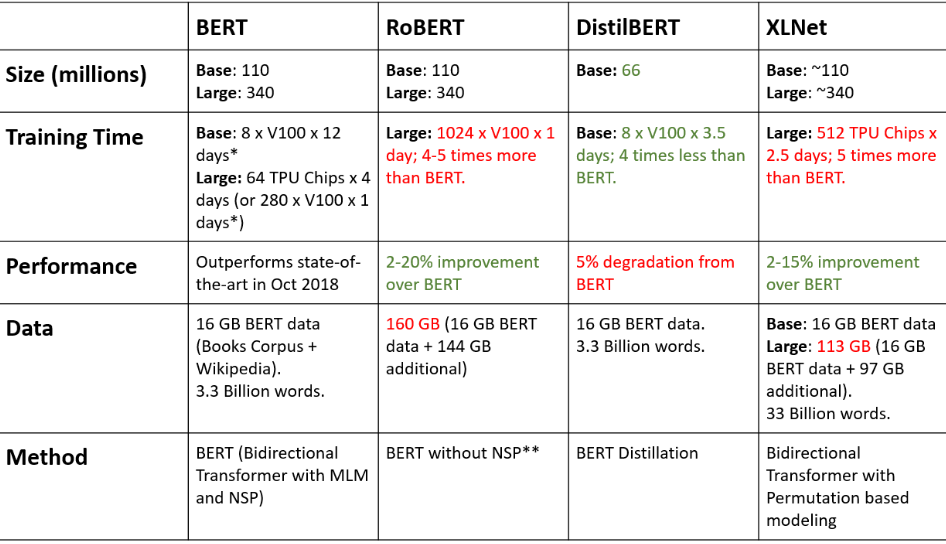


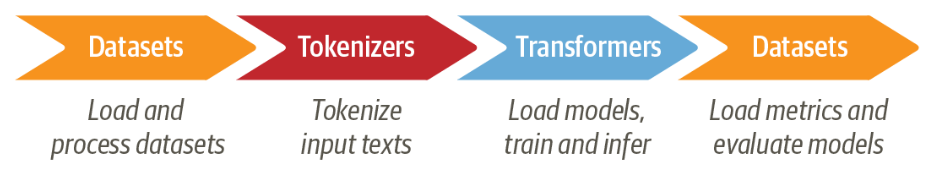

# 2.1 데이터셋

### 2.1.1 허깅페이스 데이터셋 처음 사용하기

In [1]:
from datasets import list_datasets

all_dataset = list_datasets()
print(f"현재 허브에는 {len(all_dataset)}개의 데이터셋이 있습니다.")
print(f"처음 10개의 데이터셋: {all_dataset[:10]}")

현재 허브에는 22443개의 데이터셋이 있습니다.
처음 10개의 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/jiyou/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### 2.1.2 데이터셋에서 데이터 프레임으로

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 2.1.3 클래스 분포 살펴보기

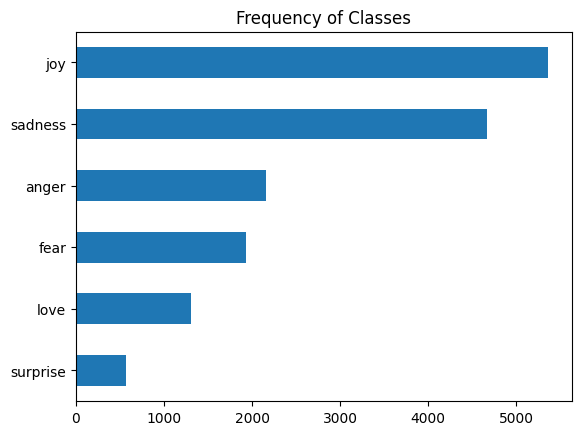

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

unproportional
1. 소수 클래스를 랜덤하게 오버샘플링
2. 다수 클래스를 랜덤하게 언더샘플링
3. 클래스의 대표성이 부족하다면 레이블링된 데이터를 더 많이 수집

https://oreil.ly/5XBhb imblearn(imbalanced)

### 2.1.4 트윗 길이 확인

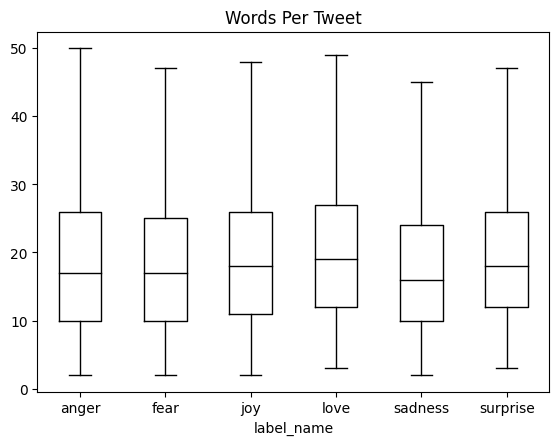

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.show()

DistilBERT의 최대 문맥 크기는 512토큰인데 여기서 감정 트윗 길이는 15개 정도이므로 텍스트를 자르지 않아도 됨 -> 정보 손실의 위험 없음

In [15]:
#이제 DataFrame format이 필요하지 않음
emotions.reset_format()

# 2.2 텍스트에서 토큰으로

### 2.2.1 문자 토큰화

In [16]:
#토큰화
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [17]:
#수치화
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [18]:
#토큰화된 텍스트를 정수 리스트로 반환
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [19]:
#input_ids를 one hot vector의 2D 텐서로 변환
#Example
#Order가 생긴다는 문제 존재
categorical_df = pd.DataFrame({"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Lable ID": [0,1,2]})
categorical_df

,Name,Lable ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [20]:
#one hot encoding
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


using pytorch to change 'input_ids' to tensor and do one-hot encoding using one_hot() function


In [21]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx)) #important to set num_classes
one_hot_encodings.shape

torch.Size([38, 20])

어휘사전을 구성하는 고유한 문자가 20개이기 때문에 (38, 20) 차원

In [22]:
print(f"token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"one-how encoding: {one_hot_encodings[0]}")

token: T
Tensor index: 5
one-how encoding: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


문자 수준의 토큰화는 텍스트의 구조를 무시하고 전체 문자열을 문자 스트링으로 처리

    1. 장점: 철자 오류나 희귀한 단어를 처리하는 데 유용
    2. 단점: 단어 같은 언어 구조를 이 데이터에서 학습해야 하기에 큰 계산, 메모리, 데이터가 필요
    3. 대체: 텍스트의 일부 구조가 유지되는 '단어 토큰화' 사용

### 2.2.2 단어 토큰화

In [23]:
#using blank to tokenize text
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


온점을 포함한 단어로 처리되고 활용형 등의 단어를 포함하면 어휘 사전이 너무 커져 신경망의 파라미터가 많이 필요해진다는 문제 존재, 이를 해결하기 위해 문자 토큰화와 단어 토큰화를 절충한 것 -> 부분단어 토큰화(subword tokenization)

### 2.2.3 부분단어 토큰화

In [24]:
#Example -> WordPiece
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [25]:
#Loading DistilBERT Tokenizer
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [26]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


The role of [CLS] and [SEP] is to let us know where this text starts and ends. 

Token replaced to the small letter.

'#' means the word is not blank. When we change token to string then these # words combined with former words.

In [28]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [29]:
tokenizer.vocab_size

30522

In [30]:
tokenizer.model_max_length

512

In [31]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 2.2.4 전체 데이터셋 토큰화하기

In [32]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Above Function set tokenizer to sample batch. If you set padding to True, that means it matches samples to batch's longest sample size. 

In [33]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


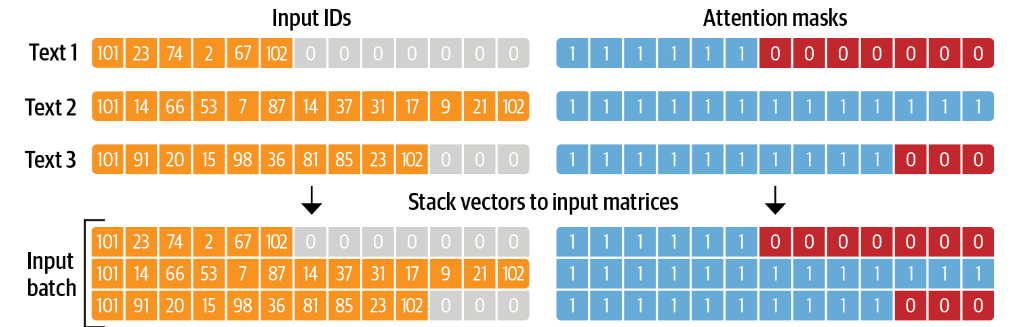

In [34]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\jiyou\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-6316da5de5436960.arrow
Loading cached processed dataset at C:\Users\jiyou\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-2cb11f4abdb48d91.arrow
Loading cached processed dataset at C:\Users\jiyou\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-1983a40220248de7.arrow


map() mathod는 말뭉치에 있는 모든 샘플에 개별적으로 작용하므로 batched를 True로 설정해 트윗을 배치로 인코딩, 배치 사이즈를 논으로 했기 때문에 전체 데이터셋이 하나의 배치로 토크나이저 함수에 적용, 이렇게 하면 입력 텐서와 어텐션 마스크가 전역적으로 동일한 크기로 생성되며 이 연산은 데이터셋에 input_ids와 attention_mask 열을 새로 추가

In [35]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# 2.3 텍스트 분류 모델 훈련하기

DistilBERT같은 인코더 기반 모델의 구조
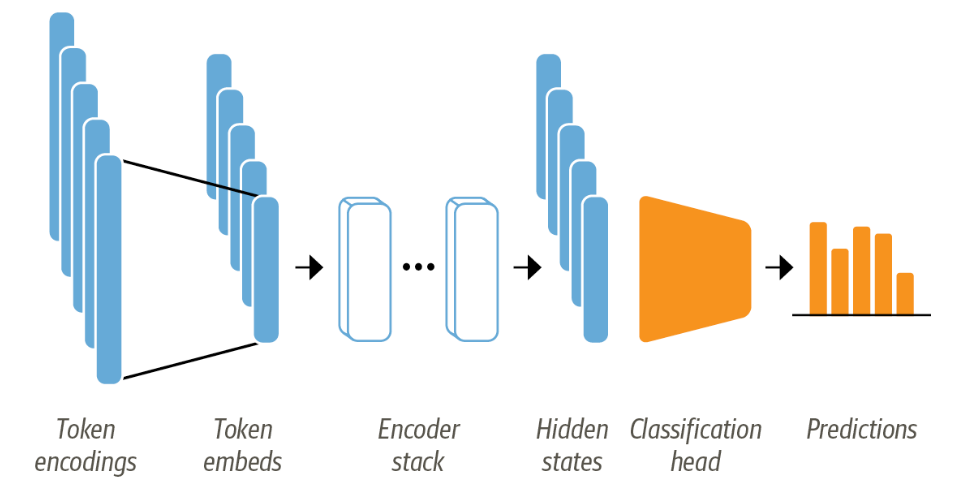

1. Tokenizing Text -> Token Encoding(One Hot Vector)
2. Transform Token Encoding to Token Embedding
3. Pass Token Embedding to Encoder Stack -> Hidden States

### 2.3.1 트랜스포머를 특성 추출기로 사용하기

훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용

    1. 장점
        1. 작거나 얕은 모델을 빠르게 훈련
        2. 이 때 훈련되는 모델은 신경망 분류 층이거나 랜덤 포레스트같이 그레디언트에 의존하지 않는 기법
        3. 은닉 상태를 한 번만 미리 계산하면 되므로 GPU를 사용하지 못할 때 편리함
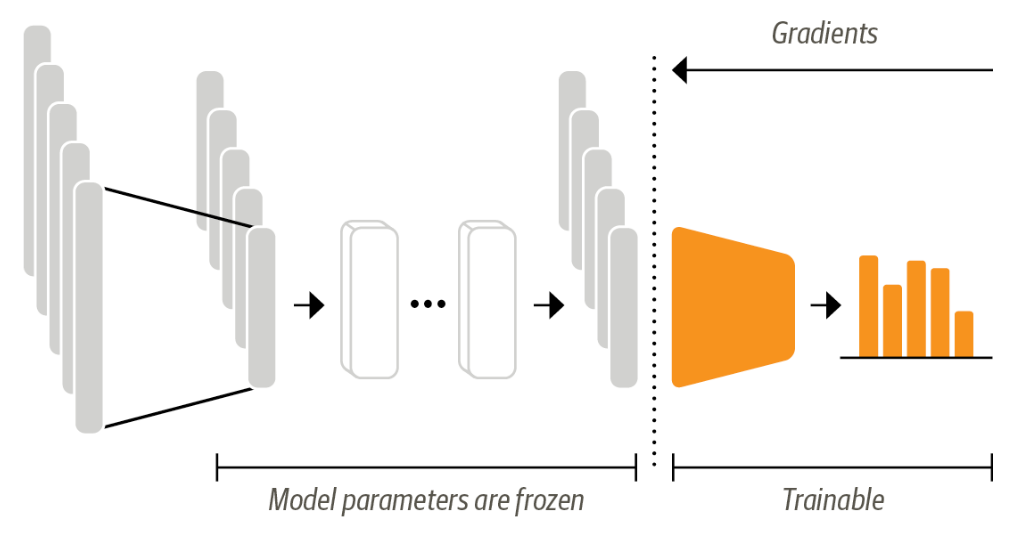

In [36]:
#사전 훈련된 모델 사용
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
#마지막 은닉 상태 추출
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt") #pt = pytorch tensor
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


(batch_size, n_tokens)

In [38]:
inputs.items

<bound method BatchEncoding.items of {'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}>

In [39]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():#To prevent gradient auto calculation 
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [40]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

(batch_size, n_tokens, hidden_dim)

In [41]:
outputs.last_hidden_state[:,0].size() #if you set output_hidden_states=True, then you can get every layer's hidden states
torch.Size([1, 768])

torch.Size([1, 768])

In [42]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
                if k in tokenizer.model_input_names}
    #Print final hidden state
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    #Return [CLS] token vector
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

This model expected get tensor, so change format of input_ids and attention_mask to torch

In [43]:
emotions_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [44]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Loading cached processed dataset at C:\Users\jiyou\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-46d3439f5d995c10.arrow
Loading cached processed dataset at C:\Users\jiyou\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-0c061444085d4464.arrow
Loading cached processed dataset at C:\Users\jiyou\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-7378edfcc2d6d964.arrow


In [45]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### 특성 행렬 만들기

In [46]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### 훈련 세트 시각화

1. 768차원의 은닉을 시각화하기는 어렵기에 UMAP을 사용해 벡터를 2D로 투영
2. UMAP은 특성이 [0,1] 사이에 있을 때 잘 동작하기에 MinMaxScaler 적용한 후 UMAP 구현으로 은닉 차원 축소

In [47]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric = "cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.405408,7.093673,0
1,-2.712771,6.221009,0
2,5.528405,3.560913,3
3,-2.031591,4.172694,2
4,-3.029494,4.147317,3


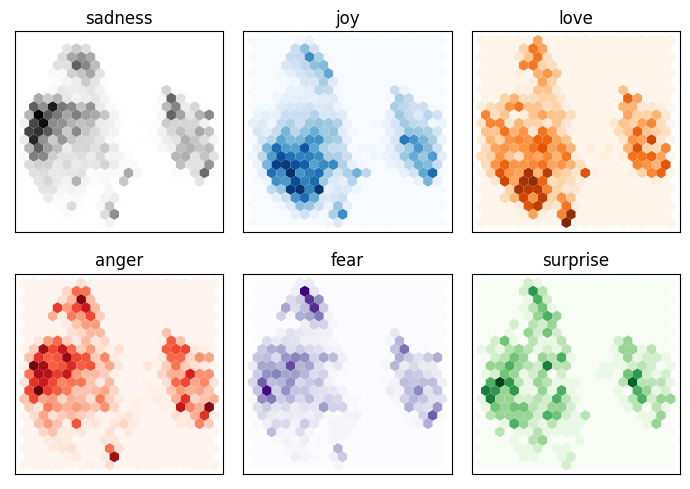

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [49]:
from sklearn.linear_model import LogisticRegression

#To make sure converge, set max_iter to the high number
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [50]:
#random model
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid, y_valid)

0.352

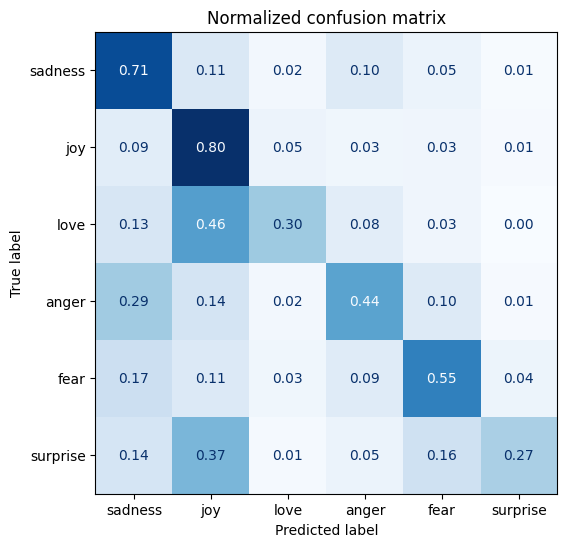

In [51]:
#To observe model quality, using confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap = "Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# 2.3.2 트랜스포머 미세 튜닝하기

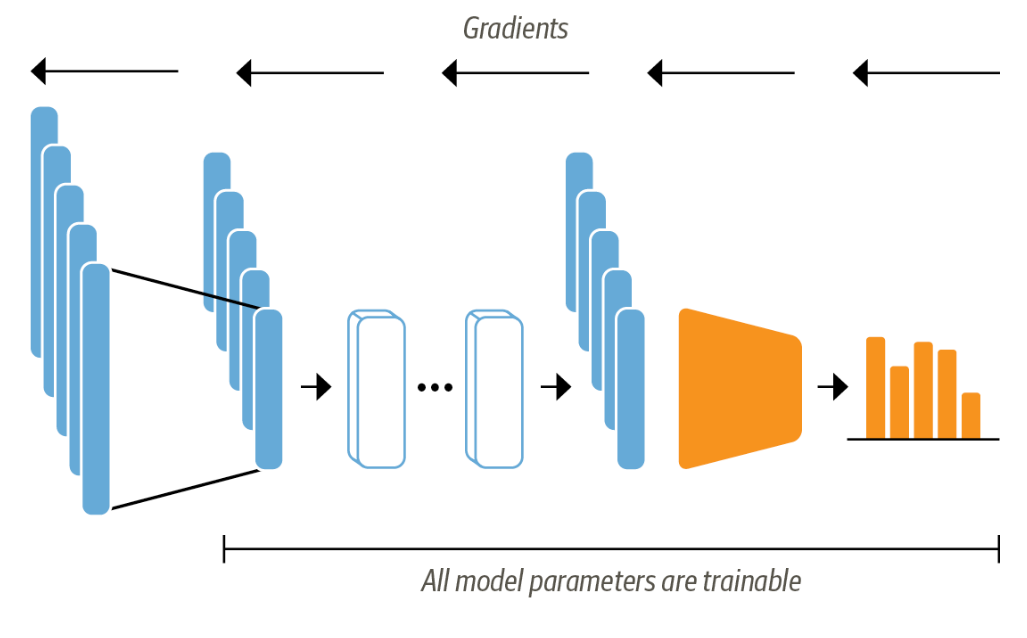

In [52]:
#Load pretrained model
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [53]:
#Set Success metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [54]:
#Train Model
from huggingface_hub import notebook_login

notebook_login()

In [55]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [56]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

C:\Users\jiyou\[Study] Natural Language Processing with Transformers\distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/SpicyDimsum/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
C:\Users\jiyou\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.844300,0.330960,0.901000,0.896050
2,0.255200,0.220604,0.924500,0.924331


TrainOutput(global_step=500, training_loss=0.5497694244384765, metrics={'train_runtime': 7328.8511, 'train_samples_per_second': 4.366, 'train_steps_per_second': 0.068, 'total_flos': 720342861696000.0, 'train_loss': 0.5497694244384765, 'epoch': 2.0})

In [57]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [58]:
preds_output.metrics

{'test_loss': 0.22060424089431763,
 'test_accuracy': 0.9245,
 'test_f1': 0.9243309432017658,
 'test_runtime': 135.669,
 'test_samples_per_second': 14.742,
 'test_steps_per_second': 0.236}

In [59]:
y_preds = np.argmax(preds_output.predictions, axis =1)

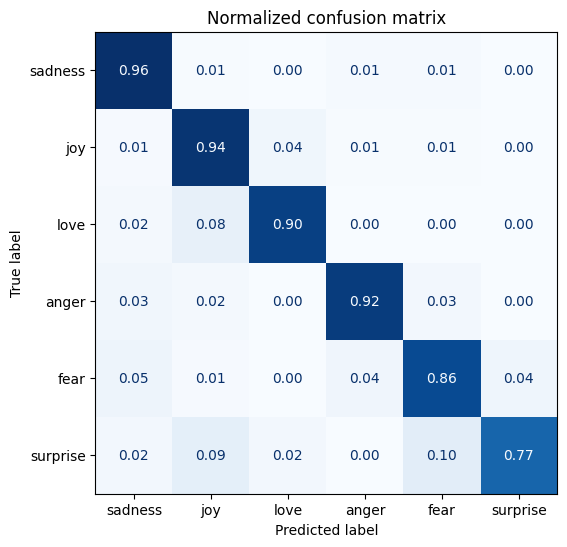

In [60]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### 오류 분석

In [67]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    #move every input tensor to model location(device)
    inputs = {k:v.to(device) for k,v in batch.items()
             if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis = -1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
        #to interconvert with other datasets' columns, move outputs to cpu
        return {"loss": loss.cpu().numpy(),
               "predicted_label":pred_label.cpu().numpy()}

In [68]:
#convert dataset to pytorch tensor
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask","label"])
#calculate loss value
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [70]:
emotions_encoded["validation"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [71]:
#Make dataframe with text, loss, pred_label
emotions_encoded.set_format("pandas")
cols = ["text","label","predicted_label","loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [72]:
#Check sample having higher loss value
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.043505
1801,i feel that he was being overshadowed by the s...,love,sadness,5.027445
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.961549
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.874538
1274,i am going to several holiday parties and i ca...,joy,sadness,4.808201
1963,i called myself pro life and voted for perry w...,joy,sadness,4.777617
1950,i as representative of everything thats wrong ...,surprise,sadness,4.727467
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.621342
1111,im lazy my characters fall into categories of ...,joy,fear,4.337757
765,i feel super awkward and out of place right now,joy,sadness,4.275775


In [73]:
#Check sample having least loss value
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
452,i manage to complete the lap not too far behin...,joy,joy,0.017627
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.017742
1873,i feel practically virtuous this month i have ...,joy,joy,0.017753
1523,i dont give a fuck because i feel like i canno...,joy,joy,0.017909
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.017997
1090,i dont know what it is about me and sweets the...,joy,joy,0.018102
1263,i feel this way about blake lively,joy,joy,0.018115
19,i had lunch with an old friend and it was nice...,joy,joy,0.018157
702,i only find out that they are looking and feel...,joy,joy,0.018166
1418,i am a big believer in the phrase that some pe...,joy,joy,0.018206


In [74]:
#Model saving and sharing
trainer.push_to_hub(commit_message="Training completed~~!!")

Upload file runs/Feb23_10-58-44_DESKTOP-78JIOIR/events.out.tfevents.1677117533.DESKTOP-78JIOIR.22532.0: 100%|#…

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/SpicyDimsum/distilbert-base-uncased-finetuned-emotion
   6338e07..41233a2  main -> main

To https://huggingface.co/SpicyDimsum/distilbert-base-uncased-finetuned-emotion
   41233a2..a60ff3b  main -> main



'https://huggingface.co/SpicyDimsum/distilbert-base-uncased-finetuned-emotion/commit/41233a2aad1a69c0c74979a324c9366f359c7fc8'

In [75]:
#using our fine tuning model to predict new tweet
from transformers import pipeline

model_id = "SpicyDimsum/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

C:\Users\jiyou\anaconda3\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jiyou\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [76]:
custom_tweet = "I ate dim sum yesterday and I almost died with pure joy"
preds = classifier(custom_tweet, return_all_scores=True)

C:\Users\jiyou\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


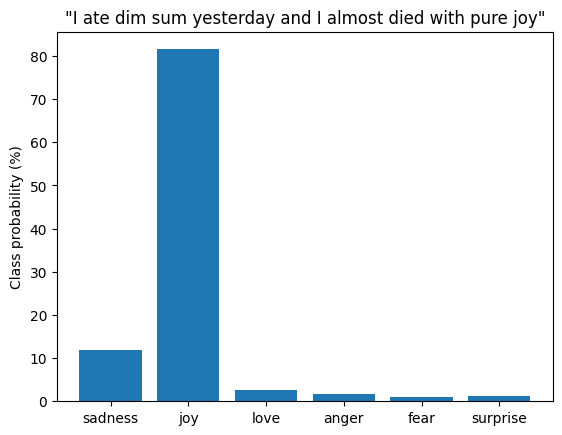

In [77]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()